In [55]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm

In [56]:
IMG_SIZE = 768
WIDTH = 1147

image_paths = glob.glob(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\*.jpg")
allImages = []
#resizing and normalizing every image
for imgFile in tqdm(image_paths, total=len(image_paths)):
  img = cv2. imread(imgFile)
  img = cv2.resize(img, (WIDTH, IMG_SIZE))
  img = img/255.0
  allImages.append(img)



images = np.array(allImages)
print(images.shape)

100%|██████████| 69/69 [00:05<00:00, 12.34it/s]


(69, 768, 1147, 3)


In [57]:
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in images],
}

In [58]:
from datasets import Dataset
# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


dataset

Dataset({
    features: ['image'],
    num_rows: 69
})

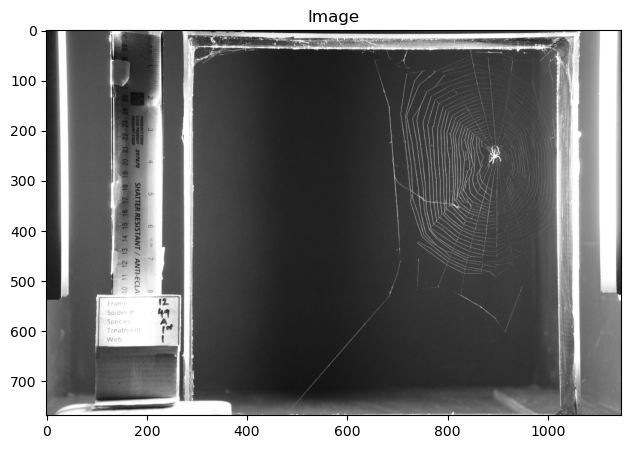

In [59]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# Plot the first image on the left
axes.imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes.set_title("Image")

# Display the image
plt.show()

In [60]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [78]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["image"])
    
    # Convert the image to RGB format
    #image = image.convert("RGB") #This line was added to make sure images are read in expected format

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [79]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [80]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [81]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False, collate_fn=collate_fn)


In [ ]:
batch = next(iter(train_dataloader)) #after this and before here code hasn't been tested
for k,v in batch.items():
  print(k,v.shape)

ValueError: too many values to unpack (expected 2)

In [ ]:
batch["ground_truth_mask"].shape

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
! set CUDA_HOME=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
! set PATH=%CUDA_HOME%\bin;%CUDA_HOME%\libnvvp;%PATH%

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

here

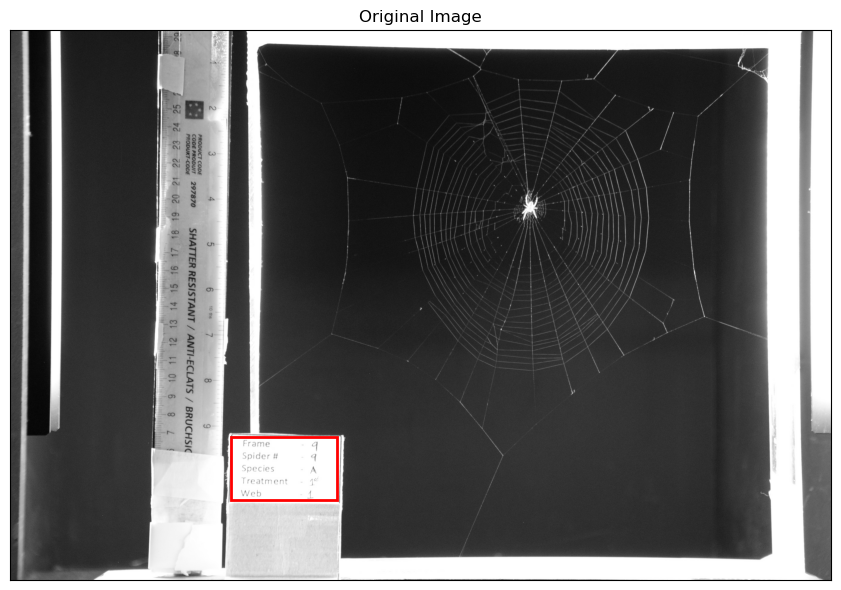

In [134]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
#my_mito_model.load_state_dict(torch.load()) #may need to change the file here
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

# Path to your new image
image_path = r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\9 - 1.jpg"
# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)
#function to find the coordinates of the box- restricted to the bottom left quadrant of the screen
def auto_detect_prompt(gray_image, box_width=500, box_height=600, step=40):
    height, width = gray_image.shape
    max_score = -1
    best_box = None

    # Search lower-left quadrant
    x_start = 0
    x_end = width // 2 - box_width
    y_start = height // 2
    y_end = height - box_height

    for y in range(y_start, y_end, step):
        for x in range(x_start, x_end, step):
            patch = gray_image[y:y+box_height, x:x+box_width]
            if patch.shape[0] != box_height or patch.shape[1] != box_width:
                continue

            # Split into top and bottom halves
            top = patch[:box_height // 2, :]
            bottom = patch[box_height // 2:, :]

            mean_top = np.mean(top)
            mean_bottom = np.mean(bottom)
            score = abs(mean_top - mean_bottom)

            if score > max_score:
                max_score = score
                best_box = [x, y, x + box_width, y + box_height]

    if best_box:
        x1, y1, x2, y2 = best_box
        # Keep only the light half (bottom)
        mid_y = y1 + (y2 - y1) // 2
        return [x1, mid_y, x2, y2]
    else:
        # Fallback to a reasonable guess (bottom-left)
        cx = int







#original
# def auto_detect_prompt(gray_image, scale_factor=0.81):  # Reduce size depends on your image
#     _, thresh = cv2.threshold(gray_image, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     if len(contours) > 0:
#         c = max(contours, key=cv2.contourArea)
#         x, y, w, h = cv2.boundingRect(c)
        
#         # Compute center of the bounding box
#         center_x, center_y = x + w // 2, y + h // 2

#         # Reduce the bounding box size
#         new_w, new_h = int(w * scale_factor), int(h * scale_factor)

#         # Compute new top-left and bottom-right coordinates
#         new_x1 = max(center_x - new_w // 2, 0)
#         new_y1 = max(center_y - new_h // 2, 0)
#         new_x2 = min(center_x + new_w // 2, gray_image.shape[1])
#         new_y2 = min(center_y + new_h // 2, gray_image.shape[0])

#         return [new_x1, new_y1, new_x2, new_y2]
#     else:
#         h, w = gray_image.shape
#         return [w//4, h//4, 3*w//4, 3*h//4]  # Default case

# Get automatic prompt (modify this logic based on your needs)
prompt = auto_detect_prompt(original_grayscale)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[prompt]],       # Use detected bounding box
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.5).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with bounding box overlay
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

# Original Image
axes.imshow(original_grayscale, cmap='gray')
axes.set_title("Original Image")
axes.add_patch(plt.Rectangle((prompt[0], prompt[1]),
                              prompt[2]-prompt[0],
                              prompt[3]-prompt[1],
                              fill=False, edgecolor='red', linewidth=2))

# Formatting

axes.set_xticks([])
axes.set_yticks([])

plt.tight_layout()
plt.show()


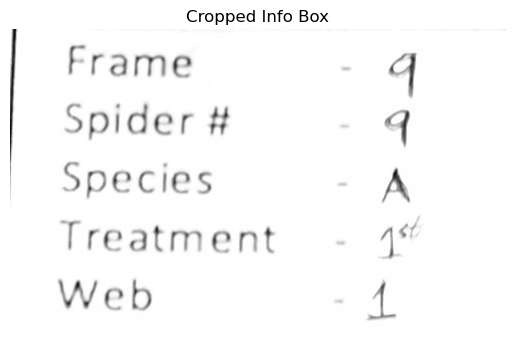

In [136]:
#Displays the cropped box
x1, y1, x2, y2 = prompt
cropped_image = original_grayscale[y1:y2, x1:x2]
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Info Box")
plt.axis('off')
plt.show()


In [137]:
#imshow function for reading the cropped image
import cv2
import pytesseract
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\adamain\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
# imshow(String titleofimage, image, float size)
def imshow(title = "Image", image = None, size = 10):
    w= image.shape[0]
    h=image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

Using CPU. Note: This module is much faster with a GPU.
c:\Users\adamain\.conda\envs\imgid\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


 Probability of Text: 99.998% OCR'd Text: Frame
 Probability of Text: 99.987% OCR'd Text: Spider #
 Probability of Text: 20.512% OCR'd Text: 4
 Probability of Text: 99.841% OCR'd Text: Species
 Probability of Text: 99.997% OCR'd Text: Treatment
 Probability of Text: 98.893% OCR'd Text: Web


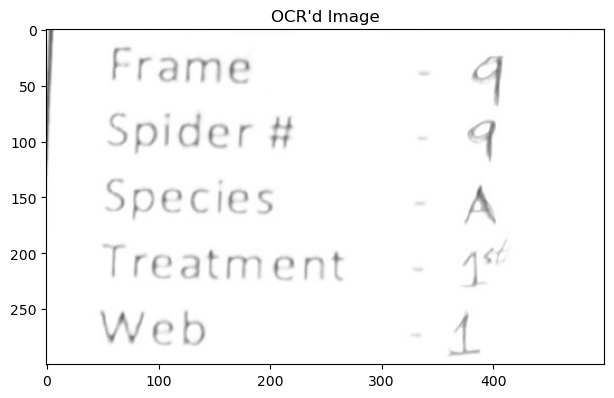

EASY OCR Extracted: ['Frame', 'Spider #', '4', 'Species', 'Treatment', 'Web']


In [138]:
from matplotlib import pyplot as plt
from easyocr import Reader


#get results from reader
reader = Reader(['en'], gpu = False)
results = reader.readtext(cropped_image)
#change back from grayscale before editing color back onto it
if len(cropped_image.shape) == 2:
    reader_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)

#edit the image
all_text = []
# iterate over our extracted text
for (bbox, text, prob) in results:
    # display the OCR'd text and the associated probability of it being text
    print(f" Probability of Text: {prob*100:.3f}% OCR'd Text: {text}")

    # get the bounding box coordinates
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))

    # Remove non-ASCII characters from the text so that
    # we can draw the box surrounding the text overlaid onto the original image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    all_text.append(text)
    for i in text:
        if (i.lower() == "frame"):
            cv2.rectangle(reader_image, tl, br, (255, 0, 0), 2)
            cv2.putText(reader_image, text, (tl[0], tl[1]-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# show the output image
imshow("OCR'd Image", cropped_image, size = 12)
print("EASY OCR Extracted: {}".format(all_text))